In [626]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

## 处理数据

In [627]:
# 绘制混淆矩阵
def plot_confusion_matrix(y_test, y_pred):
    """绘制混淆矩阵"""
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [628]:
usecols = [
    "yield_daliy",
    "activity_daliy",
    "lactation_days",
    "lactation_period",
    "disease_status",
]
data = pd.read_csv("../data/sample_test.csv", usecols=usecols)
data["disease_status"].value_counts()

乳房疾病      634
生殖系统      423
自定义疾病     244
消化系统       51
营养代谢系统     46
传染病        18
应激与过敏      15
神经系统        6
四肢疾病        4
泌尿系统        1
Name: disease_status, dtype: int64

In [629]:
data.info()
data.describe()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188572 entries, 0 to 188571
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   yield_daliy       188572 non-null  float64
 1   activity_daliy    188486 non-null  float64
 2   lactation_days    188572 non-null  int64  
 3   lactation_period  188572 non-null  int64  
 4   disease_status    1442 non-null    object 
dtypes: float64(2), int64(2), object(1)
memory usage: 7.2+ MB


,yield_daliy,activity_daliy,lactation_days,lactation_period,disease_status
0,36.905998,386.0,16,5,NaN
1,40.021999,393.0,17,5,NaN
2,39.776001,410.0,18,5,NaN
3,41.172001,382.0,19,5,NaN
4,38.122002,383.0,20,5,NaN
...,...,...,...,...,...
188567,6.160000,422.0,0,1,NaN
188568,7.500000,607.0,1,1,NaN
188569,14.750000,526.0,2,1,NaN
188570,9.230000,525.0,3,1,NaN


In [630]:
# 删除非常见的疾病类型
del_dis = ["传染病", "应激与过敏", "神经系统", "四肢疾病", "泌尿系统"]
for dis in del_dis:
    data.drop(data[data["disease_status"] == dis.strip()].index, axis=0, inplace=True)

data["disease_status"].value_counts()

乳房疾病      634
生殖系统      423
自定义疾病     244
消化系统       51
营养代谢系统     46
Name: disease_status, dtype: int64

In [631]:
# 替换为 0/1
data["disease_status"].fillna(0, inplace=True)
data["disease_status"] = data["disease_status"].apply(lambda x: 1 if x else 0)
data["disease_status"].value_counts(normalize=True)

0    0.992585
1    0.007415
Name: disease_status, dtype: float64

In [632]:
# 正负样本
data_0 = data[data["disease_status"] == 0]
data_1 = data[data["disease_status"] == 1]

# 选择 3000 个负样本
index_0 = np.random.choice(data_0.shape[0], 3000)

data_0.iloc[index_0]

,yield_daliy,activity_daliy,lactation_days,lactation_period,disease_status
61779,28.860001,427.0,304,3,0
23245,0.000000,489.0,298,5,0
146544,22.181000,520.0,321,1,0
6818,31.851999,464.0,260,5,0
166997,38.820999,498.0,48,1,0
...,...,...,...,...,...
10213,0.000000,549.0,325,5,0
78903,25.004000,343.0,326,2,0
15460,0.000000,395.0,358,4,0
103926,31.902000,611.0,121,2,0


## 训练模型

In [633]:
data.dropna(inplace=True)
y = data[["disease_status"]]
X = data.drop("disease_status", axis=1)

SEED = 28

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

In [634]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(pd.DataFrame(X_test))

In [635]:
def plot_AUC(model, X_test, y_test):
    """绘制 AUC 曲线"""
    probs = model.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()

def make_brf_modle(X_train, y_train, X_test, y_test):
    BRF = BalancedRandomForestClassifier(
        n_estimators=5,
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=2,
        min_weight_fraction_leaf=0,
        max_features="auto",
        min_impurity_decrease=0,
        bootstrap=True,
        oob_score=False,
        sampling_strategy="auto",
        replacement=False,
        n_jobs=1,
        random_state=SEED,
        verbose=2,
        warm_start=False,
        class_weight=None,
    )
    BRF.fit(X_train, y_train)
    print(f"score:{classification_report(y_test,BRF.predict(X_test))}")

    return BRF


def make_bbc_model(X_train, y_train, X_test, y_test):
    bbc = BalancedBaggingClassifier(
        estimator=DecisionTreeClassifier(),
        sampling_strategy="auto",
        replacement=True,
        random_state=42,
    )
    bbc.fit(X_train, y_train)
    print(f"score:{classification_report(y_test,bbc.predict(X_test))}")
    return bbc

## BalancedBaggingClassifier

In [636]:
bbc = make_bbc_model(X_train, y_train, X_test, y_test)

d:\Program\Python3.10\lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score:              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56122
           1       0.06      0.78      0.11       411

    accuracy                           0.91     56533
   macro avg       0.53      0.84      0.53     56533
weighted avg       0.99      0.91      0.94     56533



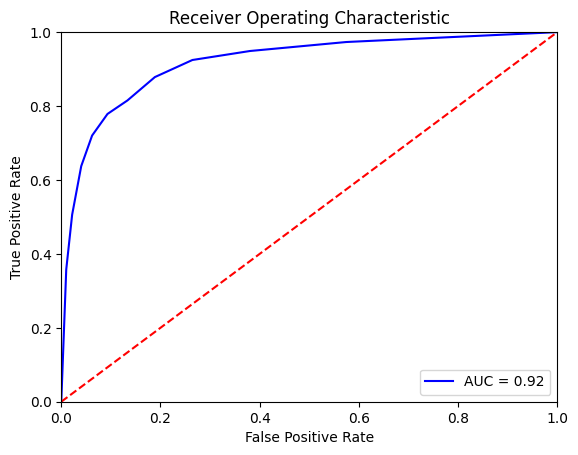

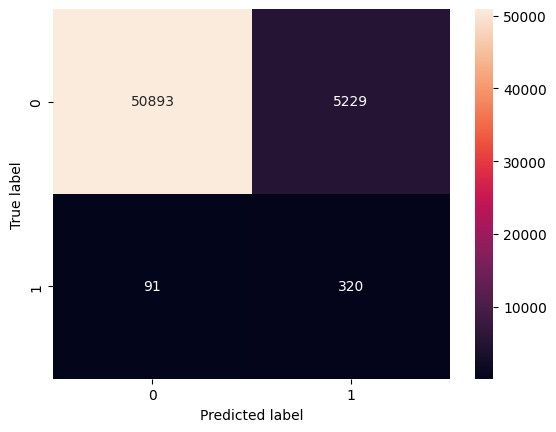

In [637]:
plot_AUC(bbc, X_test, y_test)
plot_confusion_matrix(y_test, bbc.predict(X_test))

## BalancedRandomForestClassifier

In [638]:
brf = make_brf_modle(X_train, y_train, X_test, y_test)

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
score:              precision    recall  f1-score   support

           0       1.00      0.86      0.92     56122
           1       0.04      0.83      0.08       411

    accuracy                           0.86     56533
   macro avg       0.52      0.84      0.50     56533
weighted avg       0.99      0.86      0.92     56533



C:\Users\10069\AppData\Local\Temp\ipykernel_19040\3756950965.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  BRF.fit(X_train, y_train)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
d:\Program\Python3.10\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
d:\Program\Python3.10\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
d:\Program\Python3.10\lib\site-packages\sklearn\tree\_classes.py:269: F

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


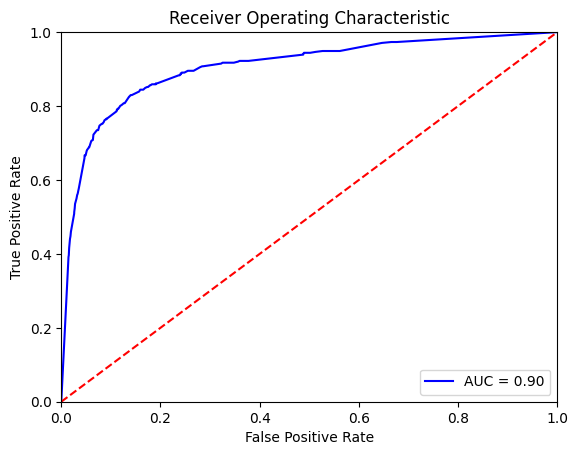

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


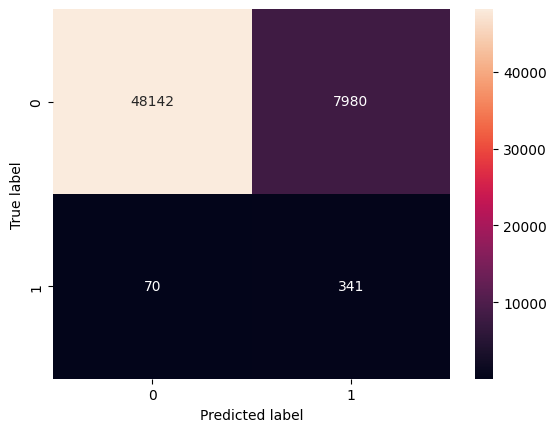

In [639]:
plot_AUC(brf, X_test, y_test)
plot_confusion_matrix(y_test, brf.predict(X_test))

## XGBClassifier

In [640]:
def make_xgb_model(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier(
        eval_metrics=["logloss", "auc", "error"],
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.7,
        objective="binary:logistic",
        scale_pos_weight=1000,
        nthread=4,
        seed=SEED,
    )
    xgb.fit(X_train, y_train)
    print(f"score:{classification_report(y_test,xgb.predict(X_test))}")
    return xgb

In [641]:
xgb = make_xgb_model(X_train, y_train, X_test, y_test)

[22:10:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "eval_metrics" } are not used.

score:              precision    recall  f1-score   support

           0       1.00      0.90      0.95     56122
           1       0.06      0.79      0.10       411

    accuracy                           0.90     56533
   macro avg       0.53      0.85      0.53     56533
weighted avg       0.99      0.90      0.94     56533



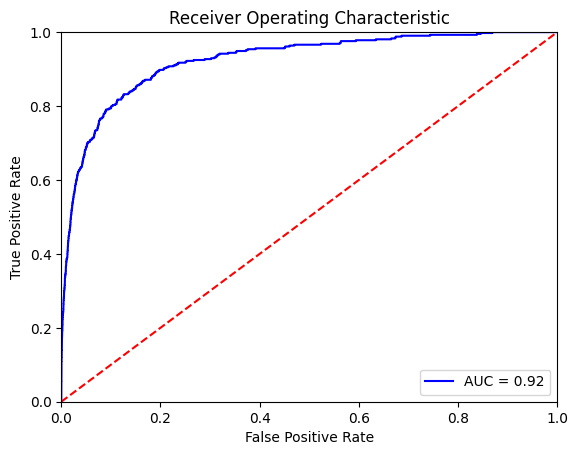

In [642]:
plot_AUC(xgb, X_test, y_test)

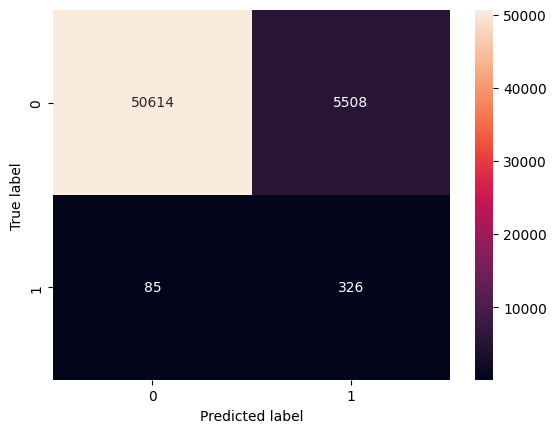

In [643]:
plot_confusion_matrix(y_test, xgb.predict(X_test))